# Bank Marketing Data - A Decision Tree Approach

## Original:
https://www.kaggle.com/shirantha/bank-marketing-data-a-decision-tree-approach
With some slight modifications

## Aim:
The aim of this attempt is to predict if the client will subscribe (yes/no) to a term deposit, by building a classification model using Decision Tree.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

In [6]:
# Load data file
bank=pd.read_csv('data/bank/bank.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Summary of data

### Categorical Variables :
**[1] job      :** admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur,
               housemaid, unknown, self-employed, student
<br>**[2] marital  :** married, single, divorced
<br>**[3] education:** secondary, tertiary, primary, unknown
<br>**[4] default  :** yes, no
<br>**[5] housing  :** yes, no
<br>**[6] loan     :** yes, no 
<br>**[7] deposit  :** yes, no ** (Dependent Variable)**
<br>**[8] contact  :** unknown, cellular, telephone
<br>**[9] month    :** jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
<br>**[10] poutcome:** unknown, other, failure, success

### Numerical Variables:
**[1] age 
<br>[2] balance
<br>[3] day
<br>[4] duration
<br>[5] campaign
<br>[6] pdays
<br>[7] previous **

In [7]:
# Check if the data set contains any null values - Nothing found!
bank[bank.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


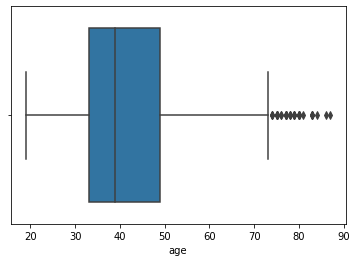

In [9]:
# Boxplot for 'age'
g = sns.boxplot(x=bank["age"])

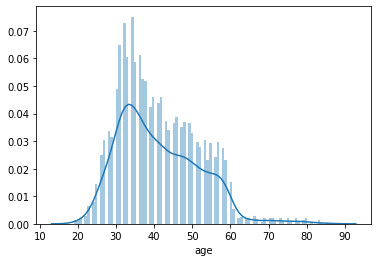

In [10]:
# Distribution of Age
sns.distplot(bank.age, bins=100)

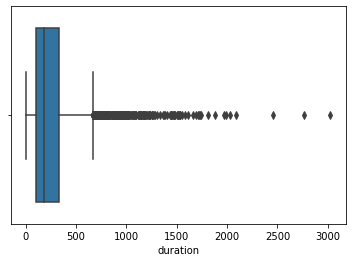

In [11]:
# Boxplot for 'duration'
g = sns.boxplot(x=bank["duration"])

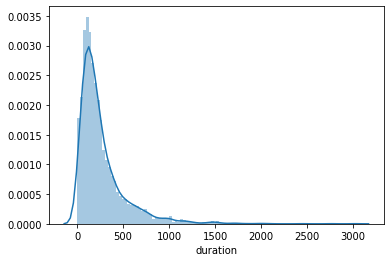

In [12]:
sns.distplot(bank.duration, bins=100)

### Convert categorical data

In [13]:
# Make a copy for parsing
bank_data = bank.copy()

#### ------------------------------ job ------------------------------

In [15]:
# Explore People who made a deposit Vs Job category
jobs = ['management','blue-collar','technician','admin.','services','retired','self-employed','student',\
        'unemployed','entrepreneur','housemaid','unknown']

for j in jobs:
    print("{:15} : {:5}". format(j, len(bank_data[(bank_data.y == "yes") & (bank_data.job ==j)])))

management      :   131
blue-collar     :    69
technician      :    83
admin.          :    58
services        :    38
retired         :    54
self-employed   :    20
student         :    19
unemployed      :    13
entrepreneur    :    15
housemaid       :    14
unknown         :     7


In [16]:
# Different types of job categories and their counts
bank_data.job.value_counts()

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

In [17]:
# Combine similar jobs into categiroes
bank_data['job'] = bank_data['job'].replace(['management', 'admin.'], 'white-collar')
bank_data['job'] = bank_data['job'].replace(['services','housemaid'], 'pink-collar')
bank_data['job'] = bank_data['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [18]:
# New value counts
bank_data.job.value_counts()

white-collar     1447
blue-collar       946
technician        768
pink-collar       529
other             480
self-employed     183
entrepreneur      168
Name: job, dtype: int64

#### ------------------------------ poutcome ------------------------------

In [19]:
bank_data.poutcome.value_counts()

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

In [20]:
# Combine 'unknown' and 'other' as 'other' isn't really match with either 'success' or 'failure'
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'] , 'unknown')
bank_data.poutcome.value_counts()

unknown    3902
failure     490
success     129
Name: poutcome, dtype: int64

#### ------------------------------ contact ------------------------------

In [21]:
# Drop 'contact', as every participant has been contacted. 
bank_data.drop('contact', axis=1, inplace=True)

#### ------------------------------ default ------------------------------

In [22]:
# values for "default" : yes/no
bank_data["default"]
bank_data['default_cat'] = bank_data['default'].map( {'yes':1, 'no':0} )
bank_data.drop('default', axis=1,inplace = True)

#### ------------------------------ housing ------------------------------

In [23]:
# values for "housing" : yes/no
bank_data["housing_cat"]=bank_data['housing'].map({'yes':1, 'no':0})
bank_data.drop('housing', axis=1,inplace = True)

#### ------------------------------ loan ------------------------------

In [24]:
# values for "loan" : yes/no
bank_data["loan_cat"] = bank_data['loan'].map({'yes':1, 'no':0})
bank_data.drop('loan', axis=1, inplace=True)

#### ------------------------------ month, day ------------------------------

In [25]:
# day  : last contact day of the month
# month: last contact month of year
# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

#### ------------------------------ deposit ------------------------------

In [28]:
# values for "deposit" : yes/no
bank_data["deposit_cat"] = bank_data['y'].map({'yes':1, 'no':0})
bank_data.drop('y', axis=1, inplace=True)

In [56]:
bank_data["deposit_cat"]

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: deposit_cat, Length: 4521, dtype: int64

#### ------------------------------ pdays ------------------------------

In [29]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign
#       -1 means client was not previously contacted

print("Customers that have not been contacted before:", len(bank_data[bank_data.pdays==-1]))
print("Maximum values on padys    :", bank_data['pdays'].max())

Customers that have not been contacted before: 3705
Maximum values on padys    : 871


In [30]:
# Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000

In [31]:
# Create a new column: recent_pdays 
bank_data['recent_pdays'] = np.where(bank_data['pdays'], 1/bank_data.pdays, 1/bank_data.pdays)

# Drop 'pdays'
bank_data.drop('pdays', axis=1, inplace = True)

In [32]:
bank_data.tail()

,age,job,marital,education,balance,duration,campaign,previous,poutcome,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays
4516,33,pink-collar,married,secondary,-333,329,5,0,unknown,0,1,0,0,0.000100
4517,57,self-employed,married,tertiary,-3313,153,1,0,unknown,1,1,1,0,0.000100
4518,57,technician,married,secondary,295,151,11,0,unknown,0,0,0,0,0.000100
4519,28,blue-collar,married,secondary,1137,129,4,3,unknown,0,0,0,0,0.004739
4520,44,entrepreneur,single,tertiary,1136,345,2,7,unknown,0,1,1,0,0.004016


### ------------------------------ Convert to dummy values ------------------------------

In [33]:
# Convert categorical variables to dummies
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies.head()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,30,1787,79,1,0,0,0,0,0,0.00010,...,0,1,0,1,0,0,0,0,0,1
1,33,4789,220,1,4,0,1,1,0,0.00295,...,0,1,0,0,1,0,0,1,0,0
2,35,1350,185,1,1,0,1,0,0,0.00303,...,0,0,1,0,0,1,0,1,0,0
3,30,1476,199,4,0,0,1,1,0,0.00010,...,0,1,0,0,0,1,0,0,0,1
4,59,0,226,1,0,0,1,0,0,0.00010,...,0,1,0,0,1,0,0,0,0,1


In [34]:
bank_with_dummies.shape

(4521, 27)

In [35]:
bank_with_dummies.describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,...,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,263.961292,2.793630,0.542579,0.016810,0.566025,0.152842,0.115240,0.002533,...,0.116788,0.618668,0.264543,0.149967,0.510064,0.298607,0.041363,0.108383,0.028534,0.863083
std,10.576211,3009.638142,259.856633,3.109807,1.693562,0.128575,0.495676,0.359875,0.319347,0.029633,...,0.321203,0.485767,0.441138,0.357078,0.499954,0.457697,0.199149,0.310898,0.166510,0.343797
min,19.000000,-3313.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,69.000000,104.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,444.000000,185.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000100,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,49.000000,1480.000000,329.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000100,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,87.000000,71188.000000,3025.000000,50.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Observations on whole population

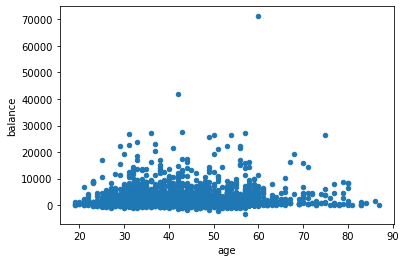

In [36]:
# Scatterplot showing age and balance
bank_with_dummies.plot(kind='scatter', x='age', y='balance');

# Across all ages, majority of people have savings of less than 20000.

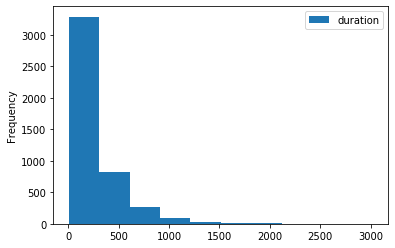

In [37]:
bank_with_dummies.plot(kind='hist', x='poutcome_success', y='duration');

#### Analysis on people who sign up for a term deposite

In [38]:
# People who sign up to a term deposite
bank_with_dummies[bank_data.deposit_cat == 1].describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.0,521.000000,...,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,42.491363,1571.955854,552.742802,2.266795,1.090211,0.017274,0.422265,0.082534,1.0,0.006372,...,0.147793,0.531670,0.320537,0.122841,0.470250,0.370441,0.036468,0.120921,0.159309,0.719770
std,13.115772,2444.398956,390.325805,2.092071,2.055368,0.130417,0.494395,0.275440,0.0,0.061874,...,0.355235,0.499476,0.467132,0.328570,0.499594,0.483387,0.187633,0.326349,0.366316,0.449543
min,19.000000,-1206.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,171.000000,260.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,710.000000,442.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000100,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,2160.000000,755.000000,3.000000,2.000000,0.000000,1.000000,0.000000,1.0,0.005051,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,87.000000,26965.000000,2769.000000,24.000000,14.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# People signed up to a term deposite having a personal loan (loan_cat) and housing loan (housing_cat)
len(bank_with_dummies[(bank_with_dummies.deposit_cat == 1) & (bank_with_dummies.loan_cat) & (bank_with_dummies.housing_cat)])

25

In [40]:
# People signed up to a term deposite with a credit default 
len(bank_with_dummies[(bank_with_dummies.deposit_cat == 1) & (bank_with_dummies.default_cat ==1)])

9

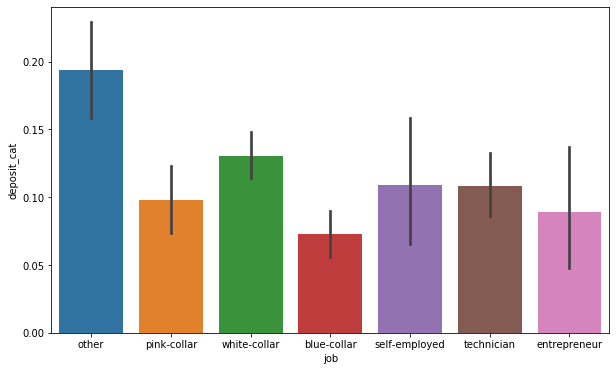

In [41]:
# Bar chart of job Vs deposite
plt.figure(figsize = (10,6))
sns.barplot(x='job', y = 'deposit_cat', data = bank_data)

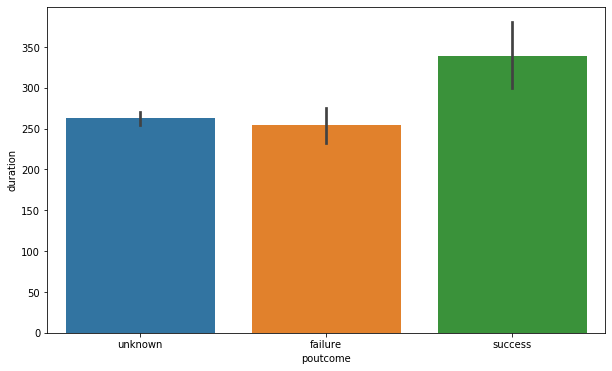

In [42]:
# Bar chart of "previous outcome" Vs "call duration"

plt.figure(figsize = (10,6))
sns.barplot(x='poutcome', y = 'duration', data = bank_data)

> ## Classification

In [43]:
# make a copy
bankcl = bank_with_dummies

In [44]:
# The Correltion matrix
corr = bankcl.corr()
corr

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
age,1.000000,0.083820,-0.002367,-0.005148,-0.003511,-0.017885,-0.193888,-0.011250,0.045092,-0.002103,...,0.148043,0.275139,-0.410768,0.224938,-0.106872,-0.094042,0.081111,0.012693,0.048626,-0.035029
balance,0.083820,1.000000,-0.015950,-0.009976,0.026196,-0.070886,-0.050227,-0.071349,0.017905,-0.004674,...,-0.036284,0.017158,0.007525,-0.001551,-0.076574,0.076487,0.019230,0.025719,0.029999,-0.037787
duration,-0.002367,-0.015950,1.000000,-0.068382,0.018080,-0.011615,0.015740,-0.004997,0.401118,-0.012351,...,0.021373,-0.036436,0.024560,-0.003640,0.023179,-0.017779,-0.010802,-0.012852,0.049255,-0.012233
campaign,-0.005148,-0.009976,-0.068382,1.000000,-0.067833,-0.012348,-0.003574,0.017120,-0.061147,-0.023233,...,-0.022157,0.022000,-0.008093,0.009746,-0.019510,0.022631,-0.020508,-0.094021,-0.058268,0.113244
previous,-0.003511,0.026196,0.018080,-0.067833,1.000000,-0.026656,0.038621,-0.022115,0.116714,0.131297,...,-0.022158,-0.017640,0.035558,-0.020439,-0.008410,0.026977,-0.004239,0.475289,0.250277,-0.551022
default_cat,-0.017885,-0.070886,-0.011615,-0.012348,-0.026656,1.000000,0.006881,0.063994,0.001303,-0.009816,...,0.048878,-0.039031,0.007391,-0.006734,0.024901,-0.021407,-0.001240,-0.040055,-0.022410,0.047075
housing_cat,-0.193888,-0.050227,0.015740,-0.003574,0.038621,0.006881,1.000000,0.018451,-0.104683,-0.035316,...,-0.001197,0.038432,-0.041449,-0.000956,0.111368,-0.098624,-0.051205,0.094246,-0.088504,-0.042363
loan_cat,-0.011250,-0.071349,-0.004997,0.017120,-0.022115,0.063994,0.018451,1.000000,-0.070517,0.008965,...,0.017798,0.032272,-0.048496,-0.016574,0.078139,-0.043434,-0.066621,-0.011652,-0.050643,0.035065
deposit_cat,0.045092,0.017905,0.401118,-0.061147,0.116714,0.001303,-0.104683,-0.070517,1.000000,0.046769,...,0.034840,-0.064643,0.045815,-0.027420,-0.028744,0.056649,-0.008870,0.014556,0.283481,-0.150460
recent_pdays,-0.002103,-0.004674,-0.012351,-0.023233,0.131297,-0.009816,-0.035316,0.008965,0.046769,1.000000,...,-0.019769,0.016323,-0.003581,-0.020722,-0.026180,0.040516,0.009764,0.036209,0.124052,-0.092825


Text(0.5, 1, 'Heatmap of Correlation Matrix')

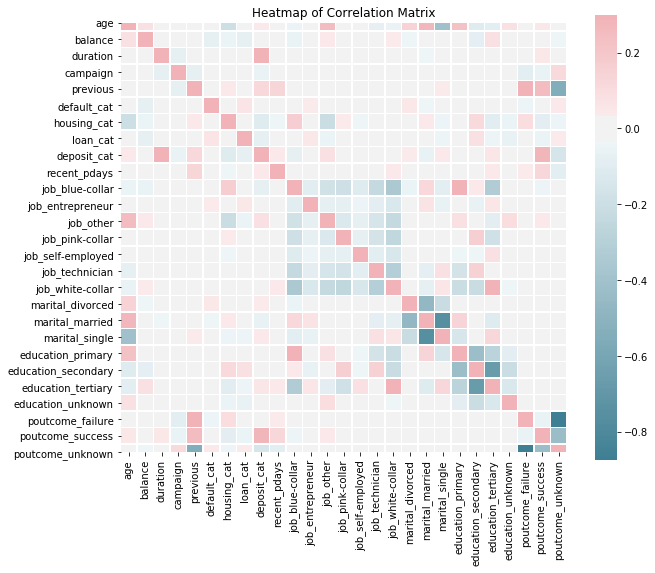

In [45]:
# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [46]:
# Extract the deposte_cat column (the dependent variable)
corr_deposite = pd.DataFrame(corr['deposit_cat'].drop('deposit_cat'))
corr_deposite.sort_values(by = 'deposit_cat', ascending = False)

,deposit_cat
duration,0.401118
poutcome_success,0.283481
previous,0.116714
job_other,0.084740
education_tertiary,0.056649
recent_pdays,0.046769
marital_single,0.045815
age,0.045092
marital_divorced,0.034840
job_white-collar,0.033036


> ## Build the Data Model

In [47]:
# Train-Test split: 20% test data
data_drop_deposite = bankcl.drop('deposit_cat', 1)
label = bankcl.deposit_cat
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.2, random_state = 50)

In [61]:
label_train

169     0
4224    1
4338    0
2774    0
2861    0
       ..
3330    0
70      1
132     0
2014    1
1931    0
Name: deposit_cat, Length: 3616, dtype: int64

In [48]:
# Decision tree with depth = 2
dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)
dt2.fit(data_train, label_train)
dt2_score_train = dt2.score(data_train, label_train)
print("Training score: ",dt2_score_train)
dt2_score_test = dt2.score(data_test, label_test)
print("Testing score: ",dt2_score_test)

Training score:  0.8985066371681416
Testing score:  0.9104972375690608


In [49]:
# Decision tree with depth = 3
dt3 = tree.DecisionTreeClassifier(random_state=1, max_depth=3)
dt3.fit(data_train, label_train)
dt3_score_train = dt3.score(data_train, label_train)
print("Training score: ",dt3_score_train)
dt3_score_test = dt3.score(data_test, label_test)
print("Testing score: ",dt3_score_test)

Training score:  0.9026548672566371
Testing score:  0.9005524861878453


In [50]:
# Decision tree with depth = 4
dt4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)
dt4.fit(data_train, label_train)
dt4_score_train = dt4.score(data_train, label_train)
print("Training score: ",dt4_score_train)
dt4_score_test = dt4.score(data_test, label_test)
print("Testing score: ",dt4_score_test)

Training score:  0.90625
Testing score:  0.8928176795580111


In [51]:
# Decision tree with depth = 6
dt6 = tree.DecisionTreeClassifier(random_state=1, max_depth=6)
dt6.fit(data_train, label_train)
dt6_score_train = dt6.score(data_train, label_train)
print("Training score: ",dt6_score_train)
dt6_score_test = dt6.score(data_test, label_test)
print("Testing score: ",dt6_score_test)

Training score:  0.9222898230088495
Testing score:  0.8961325966850828


In [52]:
# Decision tree: To the full depth
dt1 = tree.DecisionTreeClassifier()
dt1.fit(data_train, label_train)
dt1_score_train = dt1.score(data_train, label_train)
print("Training score: ", dt1_score_train)
dt1_score_test = dt1.score(data_test, label_test)
print("Testing score: ", dt1_score_test)

Training score:  1.0
Testing score:  0.861878453038674


#### Compare Training and Testing scores for various tree depths used

In [53]:
print('{:10} {:20} {:20}'.format('depth', 'Training score','Testing score'))
print('{:10} {:20} {:20}'.format('-----', '--------------','-------------'))
print('{:1} {:>25} {:>20}'.format(2, dt2_score_train, dt2_score_test))
print('{:1} {:>25} {:>20}'.format(3, dt3_score_train, dt3_score_test))
print('{:1} {:>25} {:>20}'.format(4, dt4_score_train, dt4_score_test))
print('{:1} {:>25} {:>20}'.format(6, dt6_score_train, dt6_score_test))
print('{:1} {:>23} {:>20}'.format("max", dt1_score_train, dt1_score_test))

depth      Training score       Testing score       
-----      --------------       -------------       
2        0.8985066371681416   0.9104972375690608
3        0.9026548672566371   0.9005524861878453
4                   0.90625   0.8928176795580111
6        0.9222898230088495   0.8961325966850828
max                     1.0    0.861878453038674


It could be seen that, higher the depth, training score increases and matches perfects with the training data set. However higher the depth the tree goes, it overfit to the training data set. So it's no use keep increasing the tree depth. According to above observations, tree with a depth of 2 seems more reasonable as both training and test scores are reasonably high.

In [67]:
# Let's generate the decision tree for depth = 2
# Create a feature vector
features = bankcl.drop('deposit_cat', 1).columns.tolist()

# Uncomment below to generate the digraph Tree
tree.export_graphviz(dt2, out_file='tree_depth_2.dot', class_names=['yes','no'], feature_names=features)

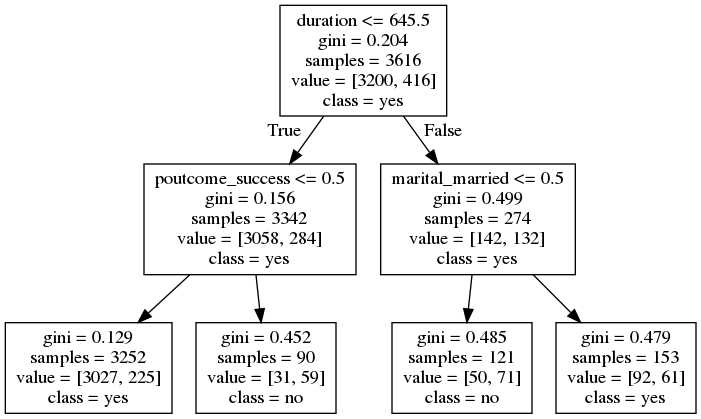

In [73]:
check_call(['dot','-Tpng','tree_depth_2.dot','-o','tree_depth_2.png'])

# Annotating chart with PIL
img = Image.open("tree_depth_2.png")
draw = ImageDraw.Draw(img)
img.save('d2.png')
PImage("d2.png")


Depth=6

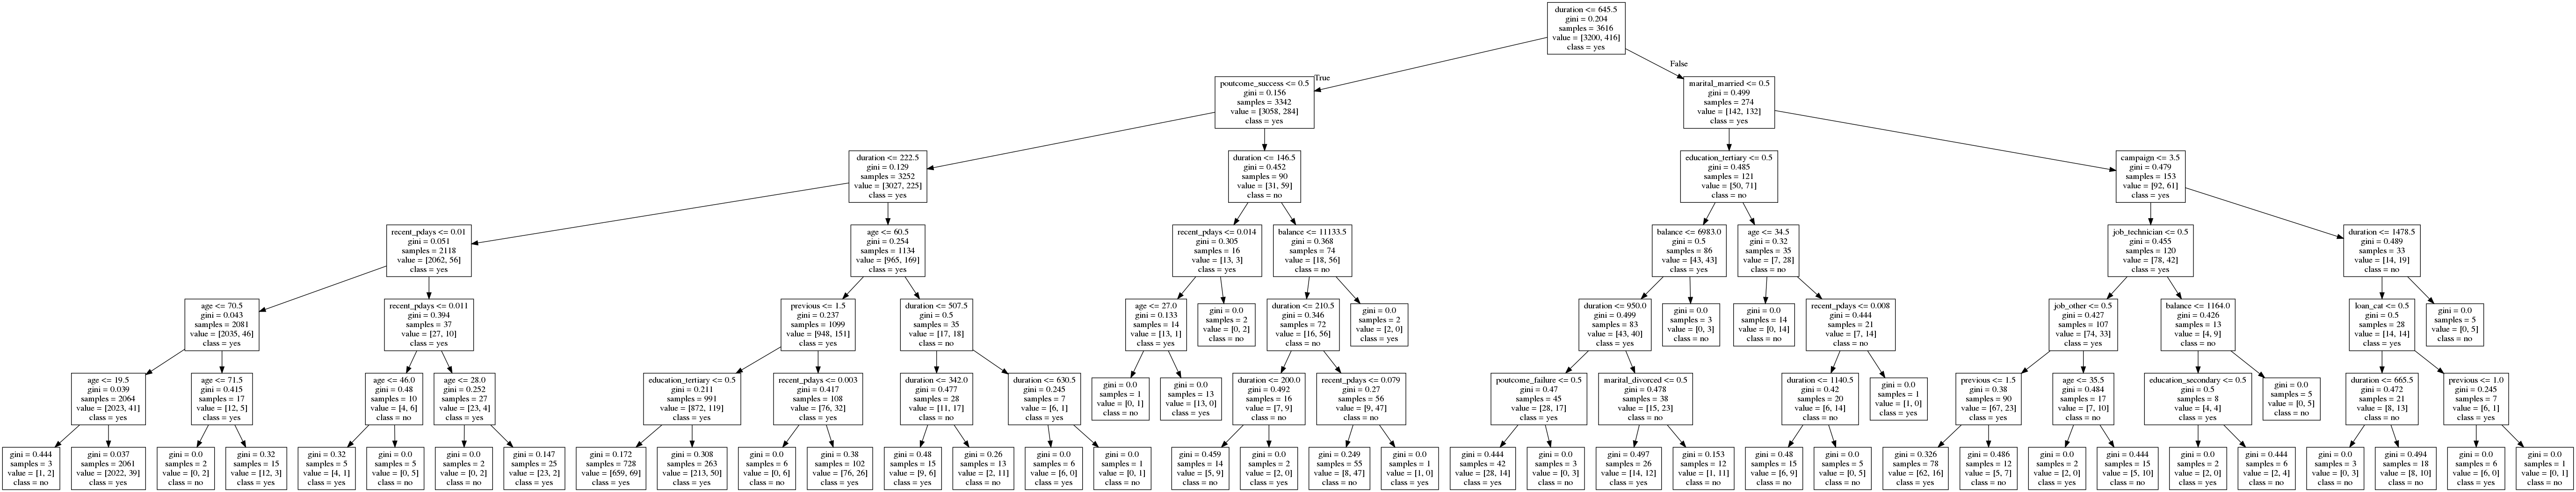

In [83]:
tree.export_graphviz(dt6, out_file='tree_depth_6.dot', class_names=['yes','no'], feature_names=features)

check_call(['dot','-Tpng','tree_depth_6.dot','-o','tree_depth_6.png'])

# Annotating chart with PIL
img = Image.open("tree_depth_6.png")
draw = ImageDraw.Draw(img)
img.save('d6.png')
PImage("d6.png")

Based on the decision tree results, it could be seen that higher the "duration", bank is able to sign up more people to term deposites.

In [74]:
# Two classes: 0 = not signed up,  1 = signed up
dt2.classes_

array([0, 1])

In [75]:
# Create a feature vector
features = data_drop_deposite.columns.tolist()

features

['age',
 'balance',
 'duration',
 'campaign',
 'previous',
 'default_cat',
 'housing_cat',
 'loan_cat',
 'recent_pdays',
 'job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [76]:
# Investigate most important features with depth =2

dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
dt2.fit(data_train, label_train)

fi = dt2.feature_importances_

l = len(features)
for i in range(0,len(features)):
    print('{:.<20} {:3}'.format(features[i],fi[i]))

age................. 0.0
balance............. 0.0
duration............ 0.5508900668917495
campaign............ 0.0
previous............ 0.0
default_cat......... 0.0
housing_cat......... 0.0
loan_cat............ 0.0
recent_pdays........ 0.0
job_blue-collar..... 0.0
job_entrepreneur.... 0.0
job_other........... 0.0
job_pink-collar..... 0.0
job_self-employed... 0.0
job_technician...... 0.0
job_white-collar.... 0.0
marital_divorced.... 0.0
marital_married..... 0.03302804023944334
marital_single...... 0.0
education_primary... 0.0
education_secondary. 0.0
education_tertiary.. 0.0
education_unknown... 0.0
poutcome_failure.... 0.0
poutcome_success.... 0.41608189286880715
poutcome_unknown.... 0.0


## Predictions

In [77]:
# According to feature importance results, most importtant feature is the "Duration"
# Let's calculte statistics on Duration
print("Mean duration   : ", data_drop_deposite.duration.mean())
print("Maximun duration: ", data_drop_deposite.duration.max())
print("Minimum duration: ", data_drop_deposite.duration.min())

Mean duration   :  263.96129174961294
Maximun duration:  3025
Minimum duration:  4


In [78]:
# Predict: Successful deposite with a call duration = 371 sec

print(dt2.predict_proba(np.array([0, 0, 371, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 371, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
# column 0: probability for class 0 (not signed for term deposite) & column 1: probability for class 1
# Probability of Successful deposite = 0.51484432

[[0.34444444 0.65555556]]
[1]


In [79]:
# Predict: Successful deposite with a maximun call duration = 3881 sec

print(dt2.predict_proba(np.array([0, 0, 3881, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 3881, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))

[[0.41322314 0.58677686]]
[1]


In [80]:
# Get a row with poutcome_success = 1
#bank_with_dummies[(bank_with_dummies.poutcome_success == 1)]
data_drop_deposite.iloc[985]

age                     58.0000
balance                543.0000
duration               264.0000
campaign                 3.0000
previous                 0.0000
default_cat              0.0000
housing_cat              0.0000
loan_cat                 1.0000
recent_pdays             0.0001
job_blue-collar          1.0000
job_entrepreneur         0.0000
job_other                0.0000
job_pink-collar          0.0000
job_self-employed        0.0000
job_technician           0.0000
job_white-collar         0.0000
marital_divorced         1.0000
marital_married          0.0000
marital_single           0.0000
education_primary        0.0000
education_secondary      1.0000
education_tertiary       0.0000
education_unknown        0.0000
poutcome_failure         0.0000
poutcome_success         0.0000
poutcome_unknown         1.0000
Name: 985, dtype: float64

In [81]:
# Predict: Probability for above

print(dt2.predict_proba(np.array([46,3354,522,1,1,0,1,0,0.005747,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0]).reshape(1, -1)))
#print(ctree.predict(np.array([46,3354,522,1,1,0,1,0,0.005747,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0]).reshape(1, -1)))

[[0.34444444 0.65555556]]


In [82]:
# Make predictions on the test set
preds = dt2.predict(data_test)

# Calculate accuracy
print("\nAccuracy score: \n{}".format(metrics.accuracy_score(label_test, preds)))

# Make predictions on the test set using predict_proba
probs = dt2.predict_proba(data_test)[:,1]

# Calculate the AUC metric
print("\nArea Under Curve: \n{}".format(metrics.roc_auc_score(label_test, probs)))


Accuracy score: 
0.9104972375690608

Area Under Curve: 
0.7855714285714285
